# Running Counter

In [1]:
# AGENCY CODE

import numpy as np
import random

class Agency:
    """
    This class acts as the service, also known as the agency,
    which holds the secret vector x and responds with the vector, plus some random noise
    """
    def __init__(self, n):
        """
        n: the size of the secret binary vector (length = number of entries)
        sigma: standard deviation of gaussian noise in each response
        """
        
        self._n = n
        self._x = np.random.randint(2, size=self._n)
        self._z = np.random.randint(2, size=self._n)
    
    @property
    def n(self):
        return self._n
    
    def get_extra_information(self, mu):
        """
        For each element of the secret vector, generate a Bernoulli random variable, 
        returning x with probability mu and 1 - x with probability 1 - mu
        
        Input
            mu: probability of true answer
        Output:
            a vector representing a probabilistic view of x
        """
        return np.vectorize(lambda xi, mu: xi if random.random() > (1 - mu) else 1 - xi)(self._x, mu)
    
    def query(self):
        """
        Input
            None (there is only one query allowed, which agency will generate)
        Output
            1/n B @ x, with gaussian noise added, mean 0, stddev sigma
        """
        
        return np.tril(np.ones((self._n, self._n))) @ self._x + self._z
    
    def guess(self, x1):
        """
        Input
            x1: Vector you guess to be secret vector
        Output
            Honest answer of fraction of correct bits in x
        """
        return np.count_nonzero(self._x == x1) / self._n

In [2]:
# ATTACKER CODE

def attack_running_counter(agcy, mu=None):
    # Get the query output and make a workspace to guess the bits
    w = agcy.query()
    # Initialize to random; any undeducible bits will guessed randomly
    # Unless we were given a mu. Then get the extra information from the agency.
    z = agcy.get_extra_information(mu) if mu else np.random.randint(2, size=agcy.n)
    # Bit vector marking which bits we have DEDUCED (not guessed)
    mask = np.zeros(agcy.n)
    
    # Half the time we can immediately deduce the first bit, so do so if possible
    if w[0] == 0:
        # Since the error is only positive, 0 means both x0 and z0 are 0. Score!
        z[0] = 0
        mask[0] = 1;
    elif w[0] == 2:
        # Since we have only seen 1 user but have reported 2, we know that both x0 and z0 are 1. Score!
        z[0] = 1
        mask[0] = 1;
    
    # Deduce bit i based on what is known of bit i - 1
    for i in range(1, agcy.n):
        # Subtract w[i-1] from w[i]
        # case -1: x[i] = 0
        # case 0: ambiguous
        # case 1: ambiguous
        # case 2: x[i] = 1
        delta = w[i] - w[i - 1]
        # Obvious cases
        if delta == -1:
            # Our counter went down; this can only mean that z[i-1] = 1 and x[i] and z[i] = 0
            z[i] = 0
            mask[i] = 1
        elif delta == 2:
            # Our counter went up by 2; this can only mean that z[i-1] = 0 and x[i] and z[i] = 1
            z[i] = 1
            mask[i] = 1
        #Subtle cases
        elif delta == 0:
            # Check if we know the last bit
            if mask[i - 1] == 1:
                # Our counter increased, but we know that both x[i-1] and z[i-1] equal 0
                # Therefore both x[i] and z[i] also equal 0
                z[i] = 0
                mask[i] = 1
            # Default to leaving random guess; at this point either x[i] = 1 or z[i] = 1, each with 1/2 probability
        elif delta == 1:
            # Check if we know the last bit
            if mask[i - 1] == 1:
                # Our counter increased, but we know that both x[i-1] and z[i-1] equal 1
                # Therefore both x[i] and z[i] also equal 1
                z[i] = 1
                mask[i] = 1
            # Default to leaving random guess; at this point either x[i] = 1 or z[i] = 1, each with 1/2 probability
    
    # Submit our guess and report the score
    return agcy.guess(z)

In [3]:
# TEST SUITE

k = 20
n_values = [100, 500, 1000, 5000]
scores_a = []
scores_b = []

for n in n_values:
    scores_a.append([])
    scores_b.append([])
    for i in range(k):
        ag = Agency(n)
        scores_a[-1].append(attack_running_counter(ag))
        scores_b[-1].append(attack_running_counter(ag, 2/3))


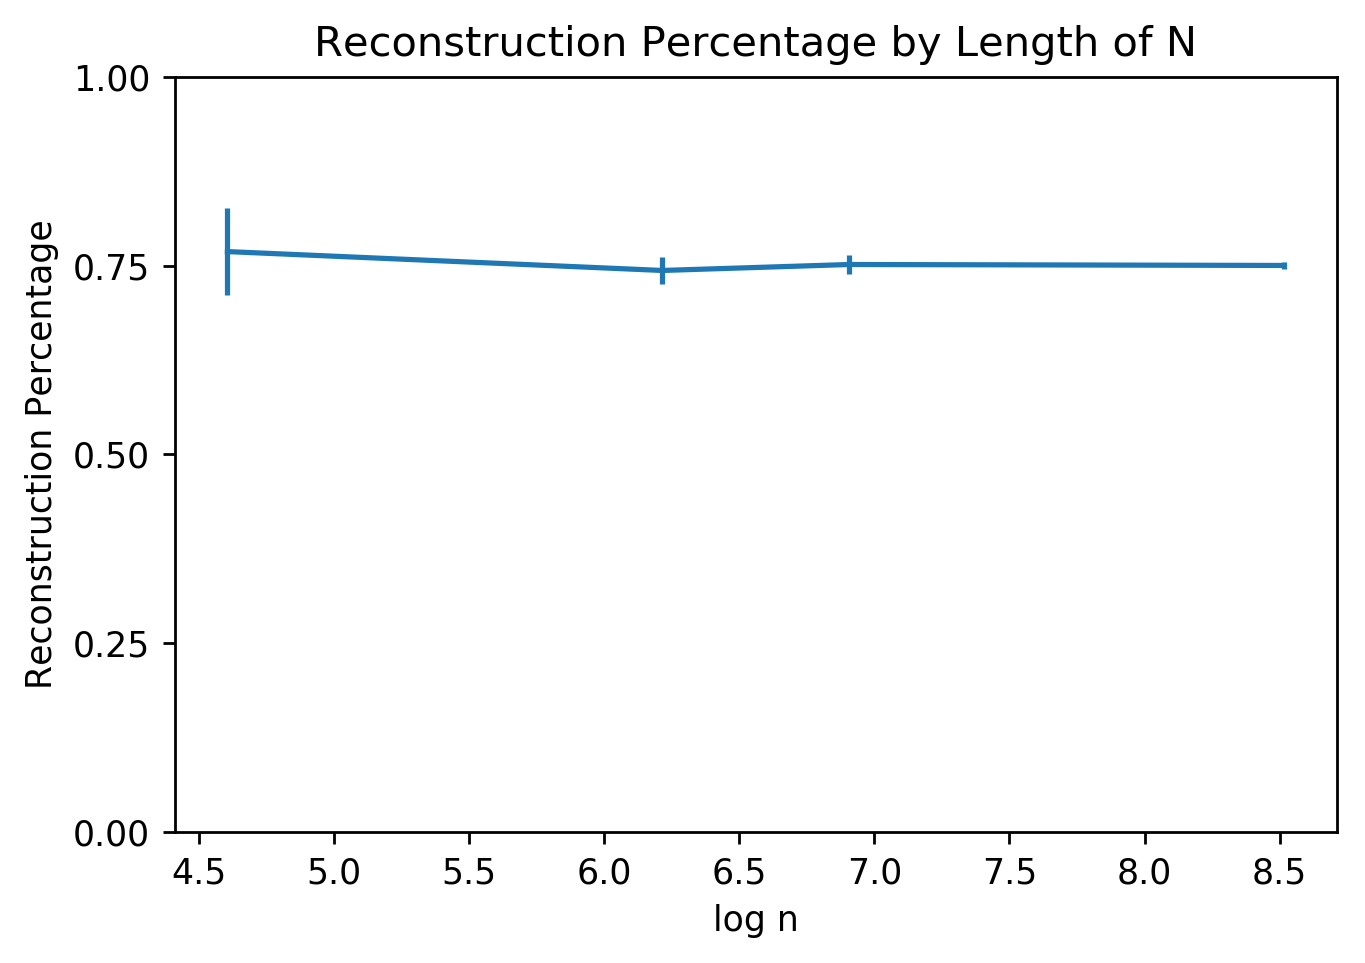

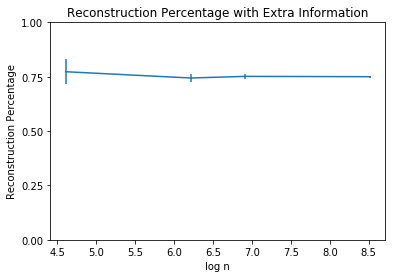

In [4]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(dpi=250)

# Reconstruction Percentage by N

Y = []
err = []
for scores in scores_a:
    Y.append(np.mean(scores))
    err.append(np.std(scores))
plt.errorbar(np.log(n_values), Y, yerr=err)

plt.xlabel('log n')
plt.ylabel('Reconstruction Percentage')
plt.ylim((0, 1))
plt.yticks(np.linspace(0, 1, 5))
plt.title("Reconstruction Percentage by Length of N")
plt.legend()
plt.show()

Y = []
err = []
for scores in scores_b:
    Y.append(np.mean(scores))
    err.append(np.std(scores))
plt.errorbar(np.log(n_values), Y, yerr=err)

plt.xlabel('log n')
plt.ylabel('Reconstruction Percentage')
plt.ylim((0, 1))
plt.yticks(np.linspace(0, 1, 5))
plt.title("Reconstruction Percentage with Extra Information")
plt.legend()
plt.show()
